In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

In [60]:
fp = 'data/nba.csv'

if not os.path.exists(fp):
    tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2017_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)

games.head()

,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,,.1,Attend.,Notes
0,0,"Tue, Oct 25, 2016",7:30 pm,New York Knicks,88,Cleveland Cavaliers,117,Box Score,NaN,20562,NaN
1,1,"Tue, Oct 25, 2016",10:30 pm,San Antonio Spurs,129,Golden State Warriors,100,Box Score,NaN,19596,NaN
2,2,"Tue, Oct 25, 2016",10:00 pm,Utah Jazz,104,Portland Trail Blazers,113,Box Score,NaN,19446,NaN
3,3,"Wed, Oct 26, 2016",7:30 pm,Brooklyn Nets,117,Boston Celtics,122,Box Score,NaN,18624,NaN
4,4,"Wed, Oct 26, 2016",7:00 pm,Dallas Mavericks,121,Indiana Pacers,130,Box Score,OT,17923,NaN


In [61]:
games.columns = ['game_id', 'date', 'start', 'away_team', 'away_points', 'home_team', 'home_points', 'Box', 'Overtime','Attendance', 'Notes']

games.head()

,game_id,date,start,away_team,away_points,home_team,home_points,Box,Overtime,Attendance,Notes
0,0,"Tue, Oct 25, 2016",7:30 pm,New York Knicks,88,Cleveland Cavaliers,117,Box Score,NaN,20562,NaN
1,1,"Tue, Oct 25, 2016",10:30 pm,San Antonio Spurs,129,Golden State Warriors,100,Box Score,NaN,19596,NaN
2,2,"Tue, Oct 25, 2016",10:00 pm,Utah Jazz,104,Portland Trail Blazers,113,Box Score,NaN,19446,NaN
3,3,"Wed, Oct 26, 2016",7:30 pm,Brooklyn Nets,117,Boston Celtics,122,Box Score,NaN,18624,NaN
4,4,"Wed, Oct 26, 2016",7:00 pm,Dallas Mavericks,121,Indiana Pacers,130,Box Score,OT,17923,NaN


In [62]:
## Replace Overtime with Binary
games.Overtime.replace(to_replace=dict(NA=0, OT=1), inplace=True)
games.Overtime.fillna(0, inplace=True)

In [63]:
games.head()

,game_id,date,start,away_team,away_points,home_team,home_points,Box,Overtime,Attendance,Notes
0,0,"Tue, Oct 25, 2016",7:30 pm,New York Knicks,88,Cleveland Cavaliers,117,Box Score,0.0,20562,NaN
1,1,"Tue, Oct 25, 2016",10:30 pm,San Antonio Spurs,129,Golden State Warriors,100,Box Score,0.0,19596,NaN
2,2,"Tue, Oct 25, 2016",10:00 pm,Utah Jazz,104,Portland Trail Blazers,113,Box Score,0.0,19446,NaN
3,3,"Wed, Oct 26, 2016",7:30 pm,Brooklyn Nets,117,Boston Celtics,122,Box Score,0.0,18624,NaN
4,4,"Wed, Oct 26, 2016",7:00 pm,Dallas Mavericks,121,Indiana Pacers,130,Box Score,1.0,17923,NaN


In [64]:
games.groupby('Overtime').count()

,game_id,date,start,away_team,away_points,home_team,home_points,Box,Attendance,Notes
Overtime,,,,,,,,,,
0.0,41,41,41,41,41,41,41,41,41,0
1.0,4,4,4,4,4,4,4,4,4,0


In [70]:
games = (games.dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points', ]]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2016-10-25,New York Knicks,88,Cleveland Cavaliers,117
1,2016-10-25,San Antonio Spurs,129,Golden State Warriors,100
2,2016-10-25,Utah Jazz,104,Portland Trail Blazers,113
3,2016-10-26,Brooklyn Nets,117,Boston Celtics,122
4,2016-10-26,Dallas Mavericks,121,Indiana Pacers,130


###  How many days did each team rest between games?

In [10]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
tidy.head()

,game_id,date,variable,team
0,0,2017-10-17,away_team,Boston Celtics
1,1,2017-10-17,away_team,Houston Rockets
2,2,2017-10-18,away_team,Milwaukee Bucks
3,3,2017-10-18,away_team,Atlanta Hawks
4,4,2017-10-18,away_team,Charlotte Hornets


In [11]:
tidy.groupby('team')['date'].diff().dt.days - 1

tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
9,9,2017-10-18,away_team,Houston Rockets,0.0
16,16,2017-10-20,away_team,Orlando Magic,1.0
17,17,2017-10-20,away_team,Atlanta Hawks,1.0
18,18,2017-10-20,away_team,Sacramento Kings,1.0
19,19,2017-10-20,away_team,Portland Trail Blazers,1.0


In [12]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
16,2017-10-20,Orlando Magic,121,Brooklyn Nets,126,1.0,1.0
17,2017-10-20,Atlanta Hawks,91,Charlotte Hornets,109,1.0,1.0
18,2017-10-20,Sacramento Kings,93,Dallas Mavericks,88,1.0,1.0
19,2017-10-20,Portland Trail Blazers,114,Indiana Pacers,96,1.0,1.0
20,2017-10-20,Cleveland Cavaliers,116,Milwaukee Bucks,97,2.0,1.0


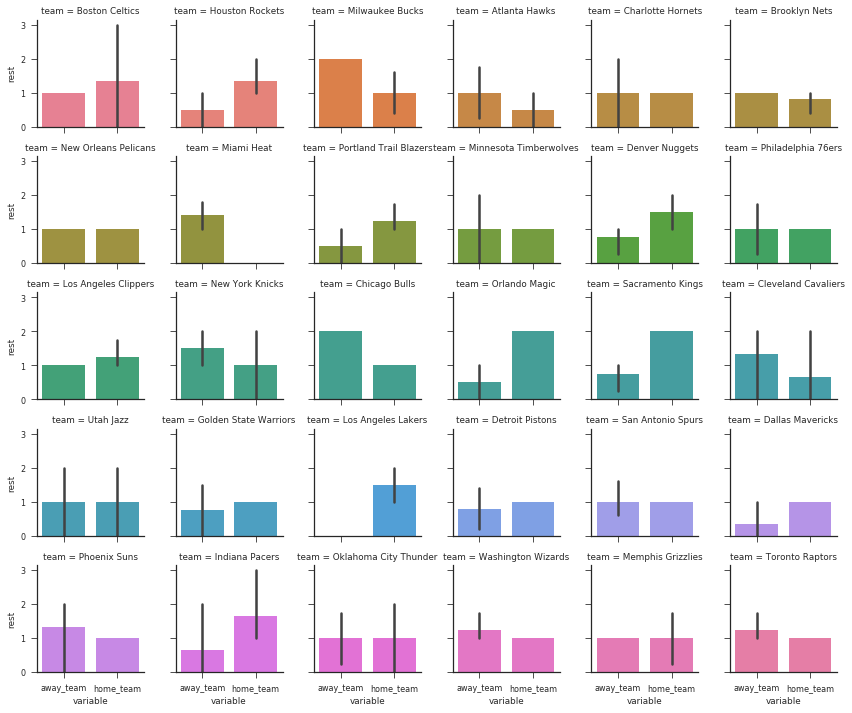

In [13]:
sns.set(style='ticks', context='paper')
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)
g.map(sns.barplot, 'variable', 'rest');

In [14]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
16,2017-10-20,Orlando Magic,121,Brooklyn Nets,126,1.0,1.0,True,0.0
17,2017-10-20,Atlanta Hawks,91,Charlotte Hornets,109,1.0,1.0,True,0.0
18,2017-10-20,Sacramento Kings,93,Dallas Mavericks,88,1.0,1.0,False,0.0
19,2017-10-20,Portland Trail Blazers,114,Indiana Pacers,96,1.0,1.0,False,0.0
20,2017-10-20,Cleveland Cavaliers,116,Milwaukee Bucks,97,2.0,1.0,False,-1.0


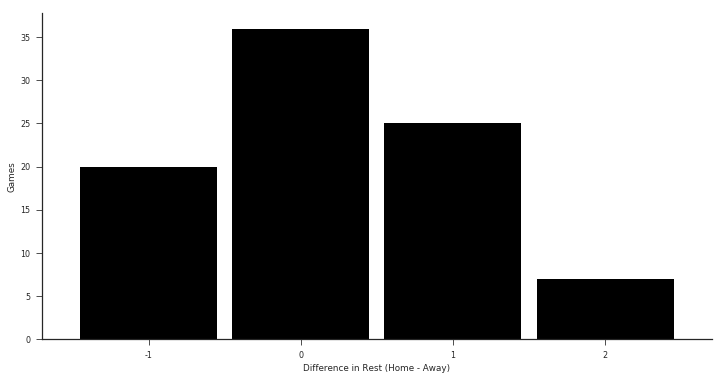

In [15]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

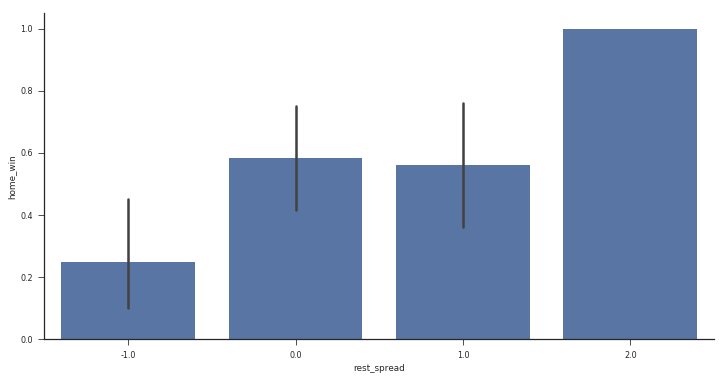

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

In [18]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.unstack().head()

variable,away_team,home_team
date,,
2017-10-18,0.000000,0.000000
2017-10-20,1.100000,1.000000
2017-10-21,0.272727,1.090909
2017-10-22,1.000000,0.666667
2017-10-23,1.125000,1.000000


In [19]:
rest.unstack().stack()

date        variable 
2017-10-18  away_team    0.000000
            home_team    0.000000
2017-10-20  away_team    1.100000
            home_team    1.000000
2017-10-21  away_team    0.272727
                           ...   
2017-10-29  home_team    1.285714
2017-10-30  away_team    0.666667
            home_team    0.888889
2017-10-31  away_team    1.500000
            home_team    1.250000
Length: 26, dtype: float64